In [1]:
# to show PA maps in browser
# usefull to check if meridians well drawn

# make figure of inflated PA maps
# and soma maps

In [1]:
folder_sharedLM = '/Users/verissimo/disks/shared_aeneas/2018/visual/SB-prep/SB-ref/derivatives/'
folder_homeLM = '/Users/verissimo/disks/verissimo_aeneas/'

In [3]:
import numpy as np
import glob, os
import pandas as pd
import nibabel as nb
import cortex

import matplotlib.colors as colors
from utils import *
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as matcm
import matplotlib.pyplot as plt
from distutils.util import strtobool

In [4]:
sj = '01'
with open('analysis_params.json','r') as json_file:	
            analysis_params = json.load(json_file)	
    

In [5]:
# define paths
with_smooth = 'True'#'False'#analysis_params['with_smooth']

# path to save figure
figure_out = os.path.join(folder_sharedLM,'figures','multimodal','sub-{sj}'.format(sj=sj))
# dir to get soma contrasts
soma_dir = os.path.join(folder_sharedLM,'soma_fit','new_fits','sub-{sj}'.format(sj=sj)) 

if with_smooth=='True':
    figure_out = os.path.join(figure_out,'smooth%d'%analysis_params['smooth_fwhm'])
    soma_dir = os.path.join(soma_dir,'smooth%d'%analysis_params['smooth_fwhm'])

if not os.path.exists(figure_out): # check if path to save figures exists
    os.makedirs(figure_out) 
    
    

In [6]:
### PRF PARAMS #######
# fit model to use (gauss or css)
fit_model = 'css' #analysis_params["fit_model"]

# if using estimates from iterative fit
iterative_fit = True #True

# total number of chunks that were fitted (per hemi)
total_chunks = analysis_params['total_chunks']
    
##

In [7]:
### POLAR ANGLES MAPS #####
# now load estimates to make polar angle
# should have run make_PA4drawing script first

prf_path = os.path.join(folder_sharedLM,'figures','prf','final_fig',fit_model)

if iterative_fit==True:
    prf_path = os.path.join(prf_path,'iterative','sub-{sj}'.format(sj=sj))
else:
    prf_path = os.path.join(prf_path,'grid','sub-{sj}'.format(sj=sj))
    
if with_smooth=='True':
    prf_path = os.path.join(prf_path,'smooth%d'%analysis_params['smooth_fwhm'])
    
# filenames
xx_filename = os.path.join(prf_path,'xx_pRF_fitmodel-%s_itertivefit-%s.npy'%(fit_model,str(iterative_fit)))
yy_filename = os.path.join(prf_path,'yy_pRF_fitmodel-%s_itertivefit-%s.npy'%(fit_model,str(iterative_fit)))

# load
print('loading visual xx from %s'%xx_filename)
masked_xx = np.load(xx_filename,allow_pickle=True)

print('loading visual yy from %s'%yy_filename)
masked_yy = np.load(yy_filename,allow_pickle=True)

rsq_threshold = 0.17

complex_location = masked_xx + masked_yy * 1j
masked_polar_angle = np.angle(complex_location)
masked_eccentricity = np.abs(complex_location)    

images = {}

# normalize polar angles to have values in circle between 0 and 1
masked_polar_ang_norm = (masked_polar_angle + np.pi) / (np.pi * 2.0)

loading visual xx from /Users/verissimo/disks/shared_aeneas/2018/visual/SB-prep/SB-ref/derivatives/figures/prf/final_fig/css/iterative/sub-01/smooth2/xx_pRF_fitmodel-css_itertivefit-True.npy
loading visual yy from /Users/verissimo/disks/shared_aeneas/2018/visual/SB-prep/SB-ref/derivatives/figures/prf/final_fig/css/iterative/sub-01/smooth2/yy_pRF_fitmodel-css_itertivefit-True.npy


In [8]:
# filename for visual rsq
rsq_visual_filename = os.path.join(figure_out,'rsq_pRF_fitmodel-%s_itertivefit-%s.npy'%(fit_model,str(iterative_fit)))
print('loading visual rsq from %s'%rsq_visual_filename)
rsq_visual = np.load(rsq_visual_filename,allow_pickle=True)
# do this to replace nans with 0s, so flatmaps look nicer
#rsq_visual = np.array([x if np.isnan(x)==False else 0 for _,x in enumerate(rsq_visual)])

loading visual rsq from /Users/verissimo/disks/shared_aeneas/2018/visual/SB-prep/SB-ref/derivatives/figures/multimodal/sub-01/smooth2/rsq_pRF_fitmodel-css_itertivefit-True.npy


In [9]:
##### make PA flatmaps with non uniform color wheel ######
# shift radians in order to overrepresent red color
# useful to make NON-REPRESENTED retinotopic hemifield per hemisphere red
# then easier to define borders

# create HSV array, with PA values (-pi to pi) that were obtained from estimates
# saturation wieghted by a shifted distribution of RSQ (better visualization)
# value bolean (if I don't give it an rsq threshold then it's always 1)

hsv_angle = []
hsv_angle = np.ones((len(rsq_visual), 3))
hsv_angle[:, 0] = masked_polar_angle.copy()
#hsv_angle[:, 1] = np.clip(rsq_visual / np.nanmax(rsq_visual) * 3, 0, 1)
hsv_angle[:, 2] = rsq_visual > rsq_threshold #np.clip(rsq_visual / np.nanmax(rsq_visual) * 3, 0, 1)#rsq_visual > 0.12 #rsq_threshold

# get mid vertex index (diving hemispheres)
left_index = cortex.db.get_surfinfo('fsaverage').left.shape[0] 

### take angles from LH (thus RVF)##
angle_ = hsv_angle[:left_index, 0].copy()
angle_thresh = 3*np.pi/4 #value upon which to make it red for this hemifield (above it or below -angle will be red)

#normalized angles, between 0 and 1
hsv_angle[:left_index, 0] = np.clip((angle_ + angle_thresh)/(2*angle_thresh), 0, 1)

### take angles from RH (thus LVF) ##
angle_ = -hsv_angle[left_index:, 0].copy() # ATENÇÃO -> minus sign to flip angles vertically (then order of colors same for both hemispheres)

# sum 2pi to originally positive angles (now our trig circle goes from pi to 2pi to pi again, all positive)
angle_[hsv_angle[left_index:, 0] > 0] += 2 * np.pi

#normalized angles, between 0 and 1
angle_ = np.clip((angle_ + (angle_thresh-np.pi))/(2*angle_thresh), 0, 1) # ATENÇÃO -> we subtract -pi to angle thresh because now we want to rotate the whole thing -180 degrees

hsv_angle[left_index:, 0] = angle_.copy()
rgb_angle = []
rgb_angle = colors.hsv_to_rgb(hsv_angle)

# make alpha same as saturation, reduces clutter
alpha_angle = hsv_angle[:, 2]


In [14]:
images['angle_half_hemi'] = cortex.VertexRGB(rgb_angle[:, 0], rgb_angle[:, 1], rgb_angle[:, 2],
                                   alpha=alpha_angle,
                                   subject='fsaverage_meridians')
#cortex.quickshow(images['angle_half_hemi'],with_curvature=True,with_sulci=True,with_colorbar=False)

FileNotFoundError: [Errno 2] No such file or directory: 'inkscape': 'inkscape'

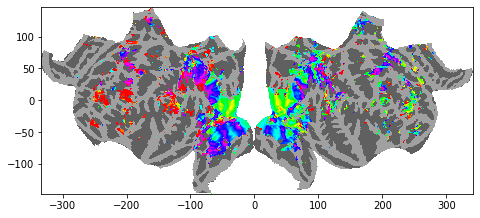

In [11]:
# Name of a sub-layer of the 'cutouts' layer in overlays.svg file
cutout_name = 'zoom_roi_right'
_ = cortex.quickflat.make_figure(images['angle_half_hemi'],
                                 with_curvature=True,
                                 with_sulci=True,
                                 with_roi=False,
                                 with_colorbar=False,
                                 cutout=cutout_name,height=2048)
filename = os.path.join(figure_out,cutout_name+'_space-fsaverage_type-PA_bins-%d.svg'%n_bins)
print('saving %s' %filename)
_ = cortex.quickflat.make_png(filename, images['angle_half_hemi'], recache=True,with_colorbar=False,
                              cutout=cutout_name,with_curvature=True,with_sulci=True,with_roi=False,height=2048)



In [11]:
## NOW DO SOMA PLOTS ###
rsq_threshold = 0 
z_threshold = analysis_params['z_threshold']

# load contrasts for different regions
face_contrast = np.load(os.path.join(soma_dir,'z_face_contrast_rsq-%.2f.npy' %(rsq_threshold)))
hand_contrast = np.load(os.path.join(soma_dir,'z_upper_limb_contrast_rsq-%.2f.npy' %(rsq_threshold)))

# plot different body areas
# but first threshold them (only show positive z-scores)
data_threshed_face = zthresh(face_contrast,threshold=z_threshold,side='above')
data_threshed_hand = zthresh(hand_contrast,threshold=z_threshold,side='above')

# mask to only show relevant voxels
rl_mask = np.array([True if np.isnan(val) else False for _,val in enumerate(data_threshed_hand)])


# all fingers in hand combined
LHfing_zscore = [] # load and append each finger z score in left hand list
RHfing_zscore = [] # load and append each finger z score in right hand list


print('Loading data for all fingers and appending in list')

for i in range(len(analysis_params['all_contrasts']['upper_limb'])//2):
    
    LHfing_zscore.append(np.load(os.path.join(soma_dir,'z_%s-all_lhand_contrast_thresh-%0.2f_rsq-%.2f.npy' 
                                 %(analysis_params['all_contrasts']['upper_limb'][i],z_threshold,rsq_threshold))))
    RHfing_zscore.append(np.load(os.path.join(soma_dir,'z_%s-all_rhand_contrast_thresh-%0.2f_rsq-%.2f.npy' 
                                              %(analysis_params['all_contrasts']['upper_limb'][i+5],z_threshold,rsq_threshold))))
   


LHfing_zscore = np.array(LHfing_zscore)
RHfing_zscore = np.array(RHfing_zscore)

# compute center of mass and appropriate z-scores for each hand
print('Computing center of mass for left hand fingers')
LH_COM , LH_avgzval = zsc_2_COM(LHfing_zscore)
print('Computing center of mass for right hand fingers')
RH_COM , RH_avgzval = zsc_2_COM(RHfing_zscore)


# all fingers left hand combined ONLY in left hand region 
# (as defined by LvsR hand contrast values)

LH_COM_4plot = LH_COM.copy()
LH_COM_4plot[rl_mask] = np.nan



images = {}

#images['v_Lfingers'] = cortex.Vertex(LH_COM_4plot, 'fsaverage_meridians',
#                           vmin=0, vmax=4,
#                           cmap='J4')#costum colormap added to database
images['v_Lfingers'] = make_raw_vertex_image(LH_COM_4plot,'J4',0,4,subject='fsaverage_meridians')

#cortex.quickshow(images['v_Lfingers'],with_curvature=True,with_sulci=True,with_colorbar=True)


# all fingers right hand combined ONLY in right hand region 
# (as defined by LvsR hand contrast values)

RH_COM_4plot = RH_COM.copy()
RH_COM_4plot[rl_mask] = np.nan

#images['v_Rfingers'] = cortex.Vertex(RH_COM_4plot, 'fsaverage_meridians',
#                           vmin=0, vmax=4,
#                           cmap='J4')#costum colormap added to database

images['v_Rfingers'] = make_raw_vertex_image(RH_COM_4plot,'J4',0,4,subject='fsaverage_meridians')

#cortex.quickshow(images['v_Rfingers'],with_curvature=True,with_sulci=True,with_colorbar=True)


# all individual face regions combined

allface_zscore = [] # load and append each face part z score in list

print('Loading data for each face part and appending in list')

for _,name in enumerate(analysis_params['all_contrasts']['face']):
    
    facedata = np.load(os.path.join(soma_dir,'z_%s-other_face_areas_contrast_thresh-%0.2f_rsq-%.2f.npy' %(name,z_threshold,rsq_threshold)))   
    allface_zscore.append(facedata)  

allface_zscore = np.array(allface_zscore)

# combine them all in same array

print('Computing center of mass for face elements %s' %(analysis_params['all_contrasts']['face']))
allface_COM , allface_avgzval = zsc_2_COM(allface_zscore)


# threshold left vs right, to only show relevant vertex 
# (i.e., where zscore is "significant", use it to mask face for plotting)
face_mask = np.array([True if np.isnan(val) else False for _,val in enumerate(data_threshed_face)])

allface_COM_4plot = allface_COM.copy()
allface_COM_4plot[face_mask] = np.nan



# 'eyebrows', 'eyes', 'mouth','tongue', , combined
#images['v_facecombined'] = cortex.Vertex(allface_COM_4plot, 'fsaverage_meridians',
#                           vmin=0, vmax=3,
#                           cmap='J4') #costum colormap added to database

images['v_facecombined'] = make_raw_vertex_image(allface_COM_4plot,'J4',0,3,subject='fsaverage_meridians')

#cortex.quickshow(images['v_facecombined'],with_curvature=True,with_sulci=True,with_colorbar=True)



Loading data for all fingers and appending in list
Computing center of mass for left hand fingers


/Users/verissimo/disks/verissimo_aeneas/SB-ref/analysis/utils.py:381: RuntimeWarning: invalid value encountered in double_scalars
  center_of_mass.append(sum(np.multiply(elem_num,elemz_thresh))/sum(elemz_thresh))
//anaconda3/envs/i36/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
//anaconda3/envs/i36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Computing center of mass for right hand fingers


//anaconda3/envs/i36/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Loading data for each face part and appending in list
Computing center of mass for face elements ['eyebrows', 'eyes', 'mouth', 'tongue']


In [15]:
ds = cortex.Dataset(polar = images['angle_half_hemi'],
                   face = images['v_facecombined'],
                   Lhand = images['v_Lfingers'],
                   Rhand = images['v_Rfingers'])

cortex.webshow(data=ds,recache=True)

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 22119


<JS: window.viewer>

In [12]:
fig_path = '3d_views_screenshots/PA_meridians'
if not os.path.exists(fig_path):  # check if path exists
        os.makedirs(fig_path)

cortex.export.save_3d_views(images['angle_half_hemi'], 
             base_name=os.path.join(fig_path,'sub-%s'%(sj)), 
             list_angles=['lateral_pivot','left','right','bottom','back',
                         'left','right'],
                  list_surfaces=['inflated','inflated','inflated','inflated','inflated',
                                'flatmap','flatmap'],
                  viewer_params=dict(labels_visible=[],
                                     overlays_visible=['rois','sulci']),
                  size=(1024 * 4, 768 * 4), trim=True, sleep=60)

Started server on port 50279
{'camera.azimuth': 180, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 0.5, 'surface.{subject}.pivot': 180, 'surface.{subject}.shift': 10, 'surface.{subject}.specularity': 0}
[Errno 2] No such file or directory: 'convert': 'convert'
{'camera.azimuth': 90, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 0.5, 'surface.{subject}.pivot': 0, 'surface.{subject}.shift': 0, 'surface.{subject}.specularity': 0}
[Errno 2] No such file or directory: 'convert': 'convert'
{'camera.azimuth': 270, 'camera.altitude': 90, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 0.5, 'surface.{subject}.pivot': 0, 'surface.{subject}.shift': 0, 'surface.{subject}.specularity': 0}
[Errno 2] No such file or directory: 'convert': 'convert'
{'camera.azimuth': 0, 'camera.altitude': 180, 'camera.target': [0, 0, 0], 'surface.{subject}.unfold': 0.5, 'surface.{subject}.pivot': 0, 'surface.{subject}.shift': 0, 'surface.{subjec

['3d_views_screenshots/PA_meridians/sub-01_lateral_pivot_inflated.png',
 '3d_views_screenshots/PA_meridians/sub-01_left_inflated.png',
 '3d_views_screenshots/PA_meridians/sub-01_right_inflated.png',
 '3d_views_screenshots/PA_meridians/sub-01_bottom_inflated.png',
 '3d_views_screenshots/PA_meridians/sub-01_back_inflated.png',
 '3d_views_screenshots/PA_meridians/sub-01_flatmap_flatmap.png',
 '3d_views_screenshots/PA_meridians/sub-01_flatmap_flatmap.png']

In [ ]:
### NEED TO ADD MOTOR AND HAVE BOTH IN BROWSER ###
# FIRST DRAW PICTOGRAMS IN OVERLAY ##